In [1]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier 
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import uniform
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR
import matplotlib.ticker as ticker


# EDA 

In [2]:
df=pd.read_csv("used_device_data.csv")

In [3]:
data=df.copy()
data
# the target is normalized_used_price

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3449,Asus,Android,15.34,yes,no,NaN,8.0,64.0,6.0,5000.0,190.0,2019,232,4.492337,6.483872
3450,Asus,Android,15.24,yes,no,13.0,8.0,128.0,8.0,4000.0,200.0,2018,541,5.037732,6.251538
3451,Alcatel,Android,15.80,yes,no,13.0,5.0,32.0,3.0,4000.0,165.0,2020,201,4.357350,4.528829
3452,Alcatel,Android,15.80,yes,no,13.0,5.0,32.0,2.0,4000.0,160.0,2020,149,4.349762,4.624188


## Splitting the data into cat and num cat

In [4]:
tipe=["int64","float64","int"]
datanum=data.select_dtypes(include=tipe)
tipe2=['object']
datacat=data.select_dtypes(include=tipe2)

In [5]:
for i in datacat:
    print(datacat[i].value_counts(ascending=True))
    


device_brand
Infinix        10
Google         15
Coolpad        22
BlackBerry     22
Microsoft      22
OnePlus        22
Karbonn        29
Spice          30
Celkon         33
Lava           36
Apple          39
Realme         41
Panasonic      47
XOLO           49
Acer           51
Gionee         56
Meizu          62
Sony           86
Nokia         106
Motorola      106
HTC           110
Honor         116
Micromax      117
Vivo          117
Alcatel       121
Asus          122
Oppo          129
Xiaomi        132
ZTE           140
Lenovo        171
LG            201
Huawei        251
Samsung       341
Others        502
Name: count, dtype: int64
os
iOS          36
Windows      67
Others      137
Android    3214
Name: count, dtype: int64
4g
no     1119
yes    2335
Name: count, dtype: int64
5g
yes     152
no     3302
Name: count, dtype: int64


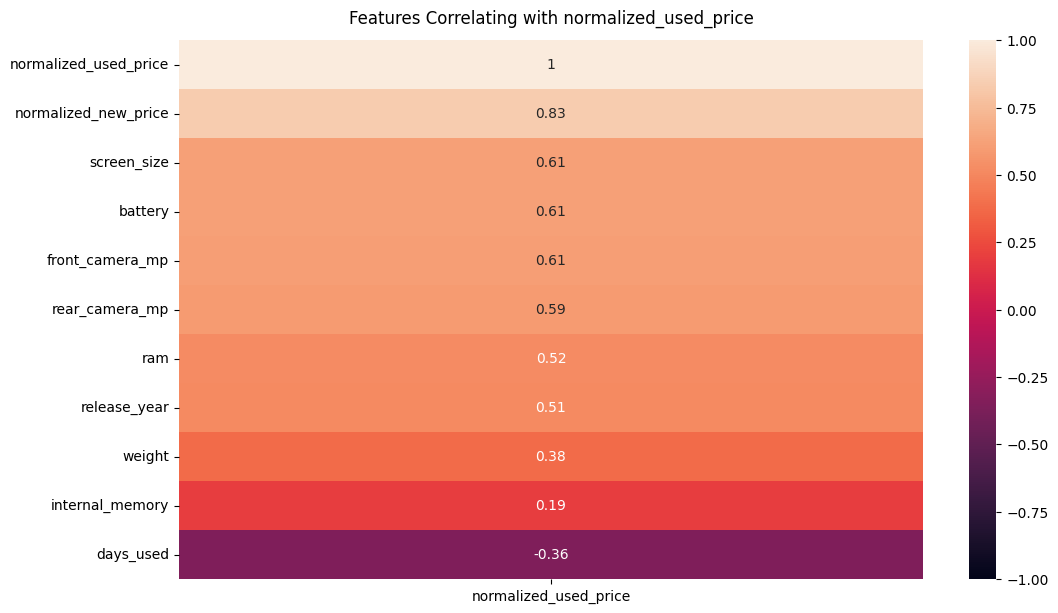

In [6]:
# the target is normalized_used_price
plt.figure (figsize = (12, 7), dpi = 100)
heatmap = sns.heatmap (datanum.corr()[['normalized_used_price']].sort_values (by = 'normalized_used_price', ascending = False), vmin = -1, vmax = 1, annot = True)
heatmap.set_title ('Features Correlating with normalized_used_price', fontdict = {'fontsize':12}, pad = 12);

In [7]:
asd=pd.DataFrame(data.normalized_used_price.sort_values(ascending=True))

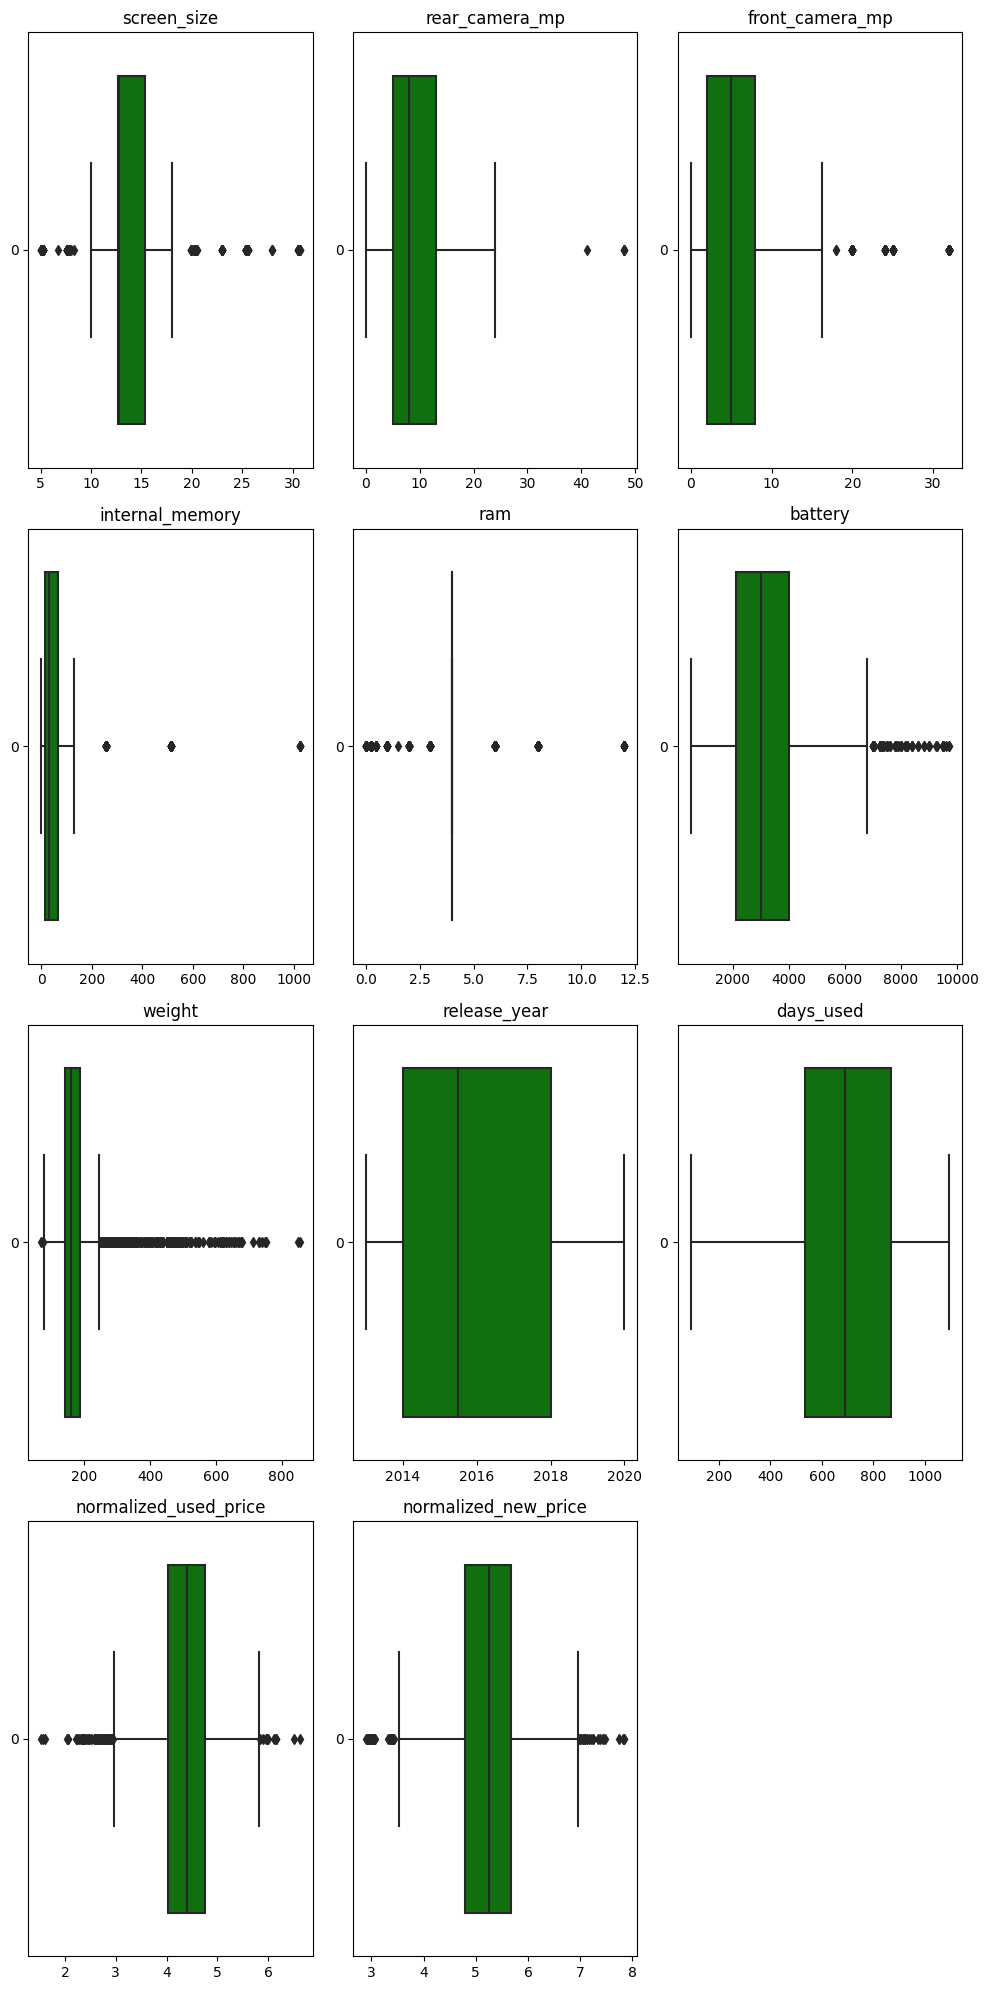

In [8]:

n_cols = 3
n_rows = (len(datanum.columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 5*n_rows))

for i, ax in enumerate(axes.flatten()):
    if i < len(datanum.columns):
        col = datanum.columns[i]
        sns.boxplot(data=datanum[col], color='green', orient="h", ax=ax)
        ax.set_title(col)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()
  





No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


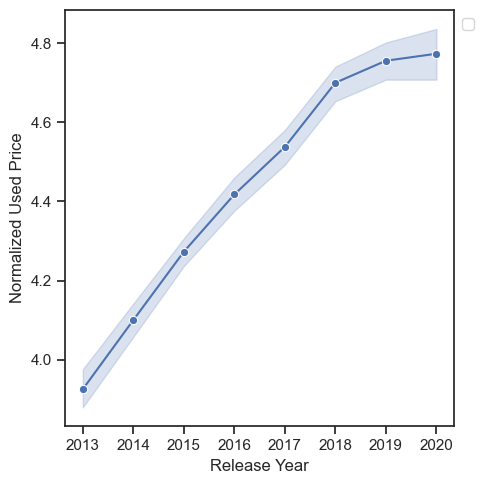

In [9]:

sns.set(style='ticks')
plt.figure(figsize=(5, 5))
sns.lineplot(data=data, x='release_year', y='normalized_used_price',marker='o')

# Customize the plot

plt.xlabel('Release Year')
plt.ylabel('Normalized Used Price')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

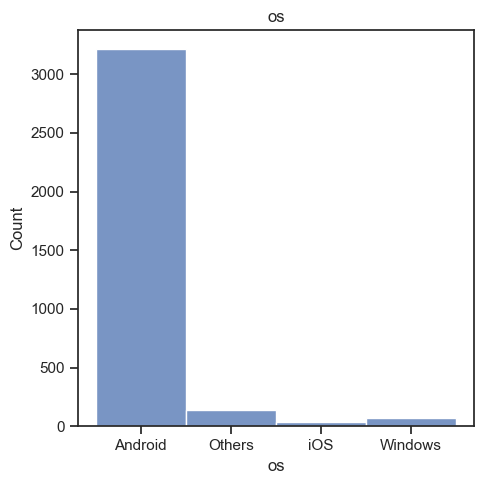

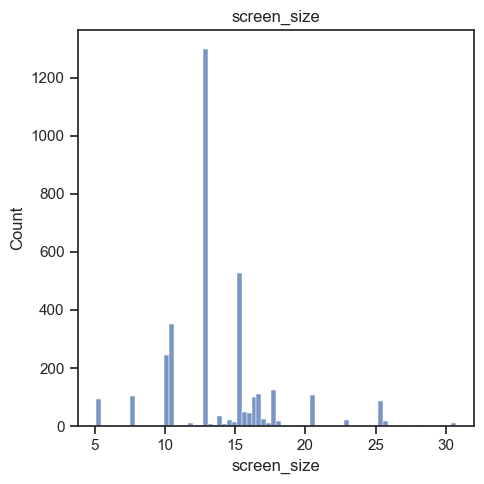

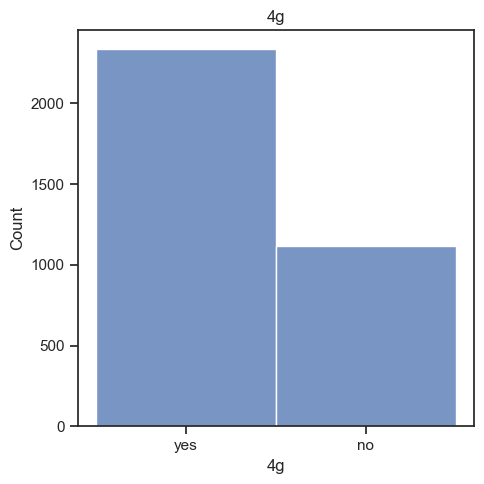

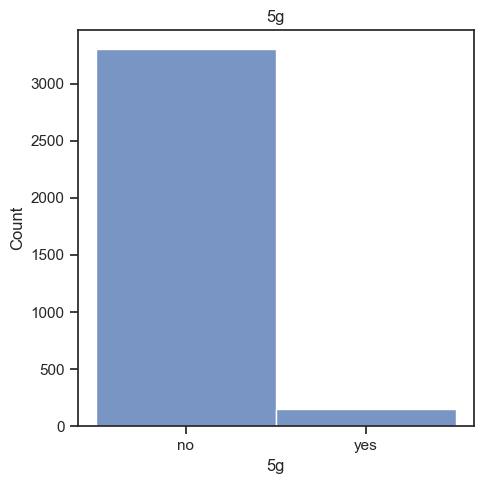

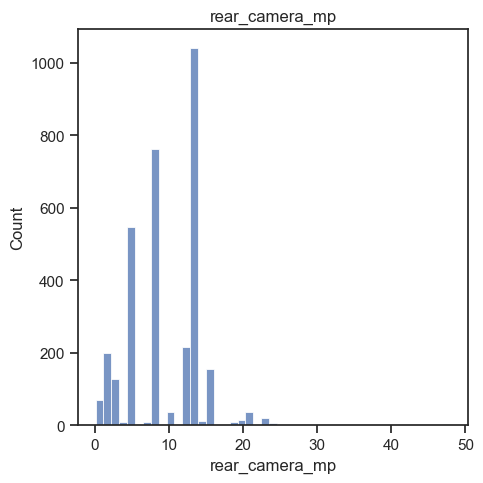

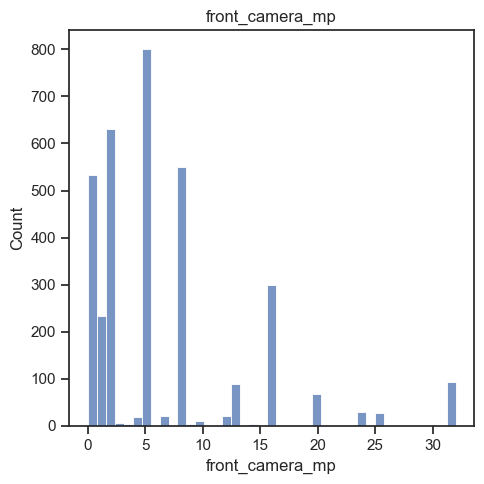

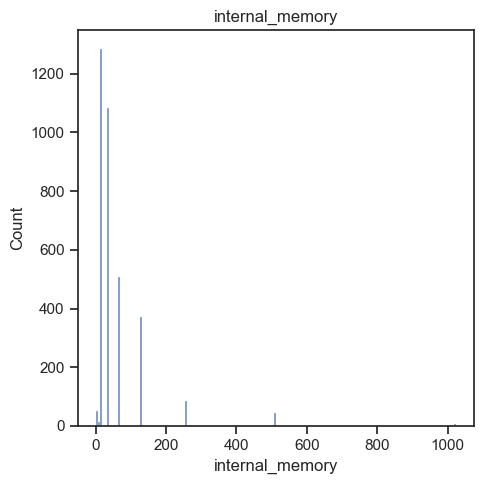

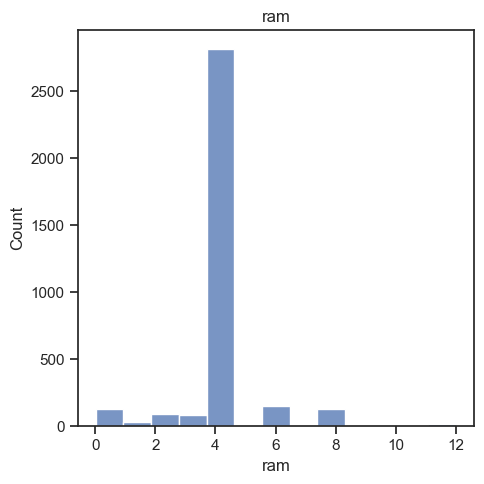

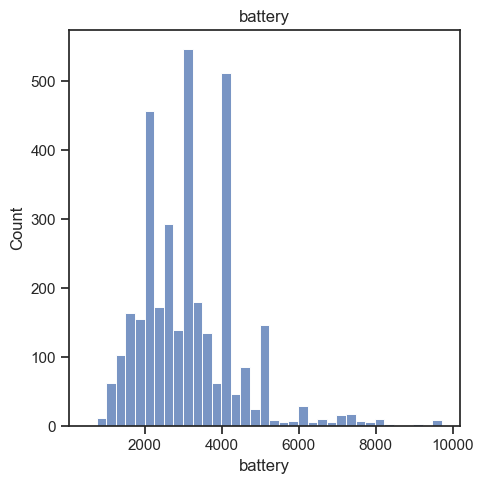

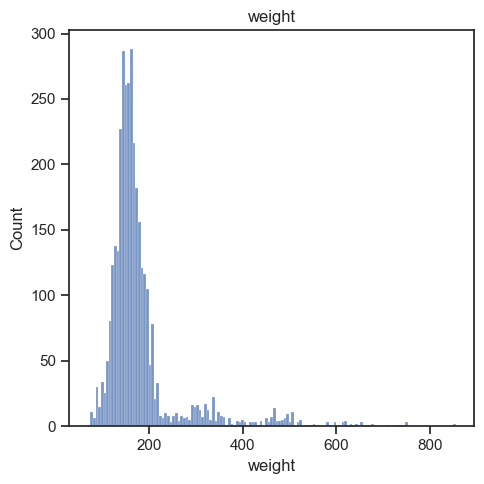

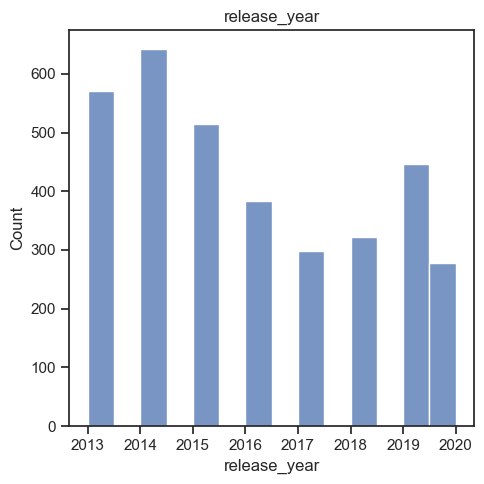

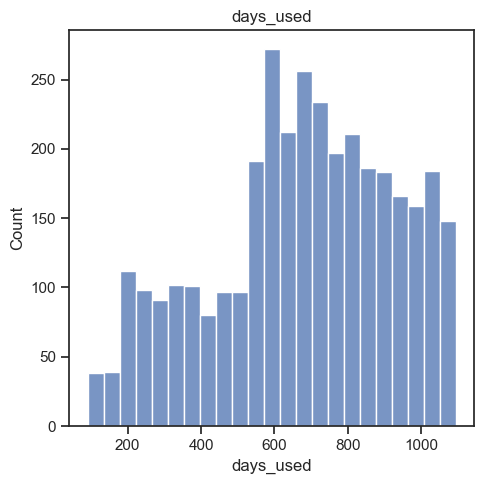

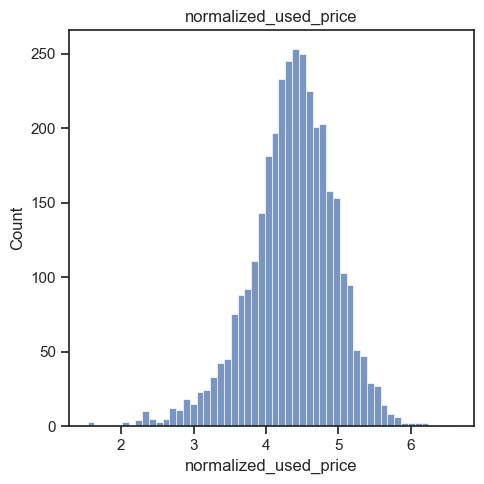

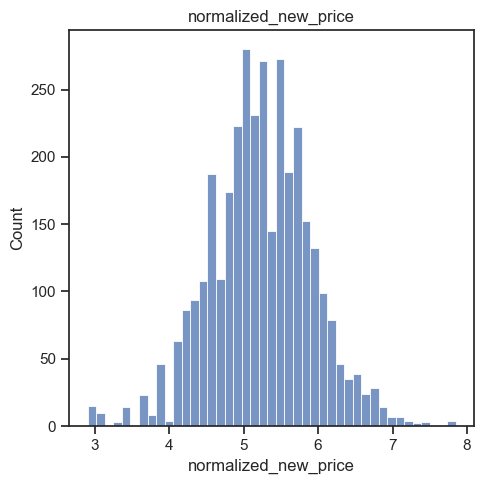

In [10]:
for i in data.drop("device_brand",axis=1):
    plt.figure(figsize=(5, 5))
    plt.title(i)
    sns.histplot(data[i])
    plt.tight_layout()

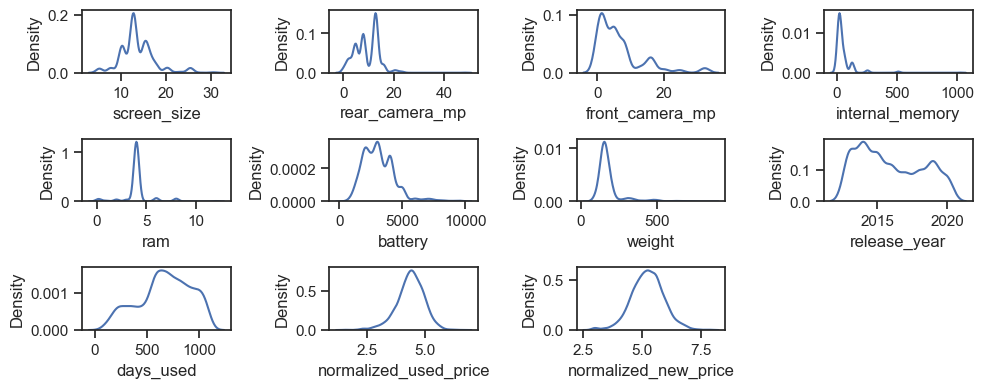

In [11]:
plt.figure(figsize=(10, 10),dpi=100)
for i in enumerate(datanum):
    plt.subplot(8,4,i[0]+1)
    sns.kdeplot(datanum[i[1]])
    plt.tight_layout()

# Preprocessing

#### Check Null

In [12]:
def check(x=data):
    for i in x.columns:
        print(f"{i} is missing with: {x[i].isnull().sum()} \t {x[i].dtype}")

check()

device_brand is missing with: 0 	 object
os is missing with: 0 	 object
screen_size is missing with: 0 	 float64
4g is missing with: 0 	 object
5g is missing with: 0 	 object
rear_camera_mp is missing with: 179 	 float64
front_camera_mp is missing with: 2 	 float64
internal_memory is missing with: 4 	 float64
ram is missing with: 4 	 float64
battery is missing with: 6 	 float64
weight is missing with: 7 	 float64
release_year is missing with: 0 	 int64
days_used is missing with: 0 	 int64
normalized_used_price is missing with: 0 	 float64
normalized_new_price is missing with: 0 	 float64


#### Check duplicates

In [13]:
data.duplicated().sum()

0

In [14]:
data.shape

(3454, 15)

#### Fill Null

In [15]:
def filling(data=data):
    for i in data.columns:
        if data[i].dtype == "object":
            print("Before filling:\n",i, data[i].isnull().sum())
            data[i].fillna(value=data[i].mode(), inplace=True)
            print("After filling:\n", i,data[i].isnull().sum())
        else:
            print("Before filling:\n", i,data[i].isnull().sum())
            data[i].fillna(value=data[i].mean(), inplace=True)
            print("After filling:\n", i,data[i].isnull().sum())


filling()

Before filling:
 device_brand 0
After filling:
 device_brand 0
Before filling:
 os 0
After filling:
 os 0
Before filling:
 screen_size 0
After filling:
 screen_size 0
Before filling:
 4g 0
After filling:
 4g 0
Before filling:
 5g 0
After filling:
 5g 0
Before filling:
 rear_camera_mp 179
After filling:
 rear_camera_mp 0
Before filling:
 front_camera_mp 2
After filling:
 front_camera_mp 0
Before filling:
 internal_memory 4
After filling:
 internal_memory 0
Before filling:
 ram 4
After filling:
 ram 0
Before filling:
 battery 6
After filling:
 battery 0
Before filling:
 weight 7
After filling:
 weight 0
Before filling:
 release_year 0
After filling:
 release_year 0
Before filling:
 days_used 0
After filling:
 days_used 0
Before filling:
 normalized_used_price 0
After filling:
 normalized_used_price 0
Before filling:
 normalized_new_price 0
After filling:
 normalized_new_price 0


### One Hot Encoding

In [16]:
for i in data.select_dtypes(include=["object"]):
    print(i)



data[['device_brand','os','4g','5g']]

device_brand
os
4g
5g


,device_brand,os,4g,5g
0,Honor,Android,yes,no
1,Honor,Android,yes,yes
2,Honor,Android,yes,yes
3,Honor,Android,yes,yes
4,Honor,Android,yes,no
...,...,...,...,...
3449,Asus,Android,yes,no
3450,Asus,Android,yes,no
3451,Alcatel,Android,yes,no
3452,Alcatel,Android,yes,no


In [17]:
# dropping (device brand) because it takes too many names 

data.drop('device_brand', inplace=True,axis=1)
data

,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Android,14.50,yes,no,13.000000,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Android,17.30,yes,yes,13.000000,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Android,16.69,yes,yes,13.000000,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Android,25.50,yes,yes,13.000000,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Android,15.32,yes,no,13.000000,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3449,Android,15.34,yes,no,9.460208,8.0,64.0,6.0,5000.0,190.0,2019,232,4.492337,6.483872
3450,Android,15.24,yes,no,13.000000,8.0,128.0,8.0,4000.0,200.0,2018,541,5.037732,6.251538
3451,Android,15.80,yes,no,13.000000,5.0,32.0,3.0,4000.0,165.0,2020,201,4.357350,4.528829
3452,Android,15.80,yes,no,13.000000,5.0,32.0,2.0,4000.0,160.0,2020,149,4.349762,4.624188


In [18]:
# one hot encoding
kolom=data[['os','4g','5g']]
for i in kolom:
    asd=pd.get_dummies(kolom, prefix=kolom.columns,dtype=int)
    print(asd)
data=pd.concat([asd,data],axis=1)
data.drop(data[['os','4g','5g']],inplace=True,axis=1)
data

      os_Android  os_Others  os_Windows  os_iOS  4g_no  4g_yes  5g_no  5g_yes
0              1          0           0       0      0       1      1       0
1              1          0           0       0      0       1      0       1
2              1          0           0       0      0       1      0       1
3              1          0           0       0      0       1      0       1
4              1          0           0       0      0       1      1       0
...          ...        ...         ...     ...    ...     ...    ...     ...
3449           1          0           0       0      0       1      1       0
3450           1          0           0       0      0       1      1       0
3451           1          0           0       0      0       1      1       0
3452           1          0           0       0      0       1      1       0
3453           1          0           0       0      0       1      1       0

[3454 rows x 8 columns]
      os_Android  os_Others  os_Windows

,os_Android,os_Others,os_Windows,os_iOS,4g_no,4g_yes,5g_no,5g_yes,screen_size,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,1,0,0,0,0,1,1,0,14.50,13.000000,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,1,0,0,0,0,1,0,1,17.30,13.000000,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,1,0,0,0,0,1,0,1,16.69,13.000000,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,1,0,0,0,0,1,0,1,25.50,13.000000,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,1,0,0,0,0,1,1,0,15.32,13.000000,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3449,1,0,0,0,0,1,1,0,15.34,9.460208,8.0,64.0,6.0,5000.0,190.0,2019,232,4.492337,6.483872
3450,1,0,0,0,0,1,1,0,15.24,13.000000,8.0,128.0,8.0,4000.0,200.0,2018,541,5.037732,6.251538
3451,1,0,0,0,0,1,1,0,15.80,13.000000,5.0,32.0,3.0,4000.0,165.0,2020,201,4.357350,4.528829
3452,1,0,0,0,0,1,1,0,15.80,13.000000,5.0,32.0,2.0,4000.0,160.0,2020,149,4.349762,4.624188


### Remove outliers for spesific columns (IQR method)

In [19]:
data[["battery","weight"]].describe()

,battery,weight
count,3454.000000,3454.000000
mean,3133.402697,182.751871
std,1298.553176,88.323566
min,500.000000,69.000000
25%,2100.000000,142.000000
50%,3000.000000,160.000000
75%,4000.000000,185.000000
max,9720.000000,855.000000


In [20]:
def iqr (df,feature):

    q1= df[feature].quantile (0.25)
    q3= df[feature].quantile (0.75)
    iqr= q3-q1

    lower_bound= q1- 1.5*iqr
    upper_bound= q3 + 1.5*iqr

    return lower_bound, upper_bound



def replace_outliers(df, feature):
  '''
  Takes a dfframe, and feature. This function will replace df that is lower and higher than the boundaries and replace it with the lower_bound and upper_bound values.
  '''
  lower_bound, upper_bound = iqr(df, feature)
  df.loc[(df[feature] < lower_bound), feature] = lower_bound
  df.loc[(df[feature] > upper_bound), feature] = upper_bound



In [21]:
kolom=data[["battery","weight"]]

for i in kolom:
    replace_outliers(data,i)

data[["battery","weight"]].describe()

,battery,weight
count,3454.000000,3454.000000
mean,3109.926148,166.932387
std,1212.455216,38.820723
min,500.000000,77.500000
25%,2100.000000,142.000000
50%,3000.000000,160.000000
75%,4000.000000,185.000000
max,6850.000000,249.500000


In [22]:
# filtered_entries = np.array([True] * len(data))
# lore=pd.DataFrame(filtered_entries,columns=["Hehehe"])
# lore.value_counts()

# Machine Learning Model

In [44]:
X=data.drop(columns=["normalized_new_price",'normalized_used_price'],axis=1)
y=data["normalized_used_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [78]:


def fit_models(models, X_train, y_train):
    fitted_models = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        fitted_models[model_name] = model
    return fitted_models

def predict_targets(fitted_models, X_test):
    predictions = {}
    for model_name, model in fitted_models.items():
        predictions[model_name] = model.predict(X_test)
    return predictions

def evaluate_models(fitted_models, X_test, y_test, evaluation_metrics):
    evaluations = {}
    for model_name, model in fitted_models.items():
        y_pred = model.predict(X_test)
        evaluations[model_name] = {}
        for metric_name, metric_func in evaluation_metrics.items():
            evaluations[model_name][metric_name] = metric_func(y_test, y_pred)
    return evaluations

def train_score(fitted_models, X_train,y_train):
    train_scoring = {}
    for model_name, model in fitted_models.items():
        y_pred = model.predict(X_test)
        train_scoring[model_name] = model.score(X_train, y_train)
    return train_scoring


def test_score(fitted_models,  X_test, y_test):
    test_scoring = {}
    for model_name, model in fitted_models.items():
        y_pred = model.predict(X_test)
        test_scoring[model_name] = model.score(X_test, y_test)
    return test_scoring

# Evaluation metrics
evaluation_metrics = {
    "RMSE": mean_squared_error,
    "MAE": mean_absolute_error,
    "R2": r2_score
}

# Create a dictionary of regression models
models = {
    'linear_regression': LinearRegression(),
    'decision_tree': DecisionTreeRegressor(),
    'random_forest': RandomForestRegressor()
}

# Fit the models on the training data
fitted_models = fit_models(models, X_train, y_train)

# Predict targets for the test data
predictions = predict_targets(fitted_models, X_test)

# Evaluate the performance of the models
evaluations = evaluate_models(fitted_models, X_test, y_test, evaluation_metrics)

# Score for each prediction
train = train_score(fitted_models, X_train,y_train)
test = test_score(fitted_models, X_test, y_test)
# Print the evaluations and scoring results
for model_name, metrics in evaluations.items():
    print(f"\nEvaluations for {model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")

print("\nTrain Scoring results:")
for model_name, score_value in train.items():
    print(f"{model_name} train_score: {score_value}")


print("\n Test Scoring results:")
for model_name, score_value in test.items():
    print(f"{model_name} test_score: {score_value}")



Evaluations for linear_regression:
RMSE: 0.08929637770273217
MAE: 0.22172817442753973
R2: 0.7377783430193585

Evaluations for decision_tree:
RMSE: 0.1328930994732994
MAE: 0.2755290888881389
R2: 0.609755181098286

Evaluations for random_forest:
RMSE: 0.07001154589126418
MAE: 0.2036882883573095
R2: 0.7944088658052946

Train Scoring results:
linear_regression train_score: 0.7605923508125153
decision_tree train_score: 1.0
random_forest train_score: 0.9717490806224747

 Test Scoring results:
linear_regression test_score: 0.7377783430193585
decision_tree test_score: 0.609755181098286
random_forest test_score: 0.7944088658052946
